In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%store -r dm
dm=dm

In [39]:
dm.combine_all_data()

['X_test_estimated_a', 'data_A']
['X_test_estimated_b', 'data_B']
['X_test_estimated_c', 'data_C']


In [40]:
from sklearn.model_selection import train_test_split 

X = dm.data.iloc[:, 2:]
X["week_number"] = X["week_number"].astype(float)
y = dm.data.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_submission = dm.X_test_estimated[dm.X_test_estimated.columns.intersection(X.columns)]
X_submission["week_number"] = X_submission["week_number"].astype(float)
cols = X.columns
num_cols = [i for i in range(0, X.shape[1])]
X.columns = num_cols
X_submission.columns = num_cols

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_submission.shape)

X.columns == X_submission.columns

(36588, 48) (36588,) (12196, 48) (12196,) (2160, 48)


/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_23800/1840637959.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submission["week_number"] = X_submission["week_number"].astype(float)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [14]:
import lightgbm as lgbm

model = lgbm.LGBMRegressor(**{'learning_rate': 0.08296453124126314, 'n_estimators': 916, 'random_state': 876, 'loss': 'linear'})

In [25]:
import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential']),
    }
    model = lgbm.LGBMRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2023-11-05 15:18:45,846] A new study created in memory with name: no-name-8d895ba6-f487-4c43-bf28-09bc63d8c43f
[I 2023-11-05 15:18:48,032] Trial 0 finished with value: 182.63399252449793 and parameters: {'learning_rate': 0.6558514022974242, 'n_estimators': 457, 'random_state': 821, 'loss': 'linear'}. Best is trial 0 with value: 182.63399252449793.
[I 2023-11-05 15:18:52,443] Trial 1 finished with value: 145.6636624877233 and parameters: {'learning_rate': 0.2135367032000178, 'n_estimators': 972, 'random_state': 107, 'loss': 'exponential'}. Best is trial 1 with value: 145.6636624877233.
[I 2023-11-05 15:18:54,395] Trial 2 finished with value: 191.9134599555772 and parameters: {'learning_rate': 0.7042001420462966, 'n_estimators': 400, 'random_state': 218, 'loss': 'square'}. Best is trial 1 with value: 145.6636624877233.
[I 2023-11-05 15:18:54,755] Trial 3 finished with value: 159.60828557462258 and parameters: {'learning_rate': 0.10418473774178647, 'n_estimators': 53, 'random_state': 3

In [26]:
model.fit(X_train, y_train)

LGBMRegressor()

In [27]:
import pandas as pd 
from sklearn.metrics import mean_absolute_error
preds_A = pd.DataFrame(model.predict(X_test))
actual = y_test

# preds_A = dm.scaling(preds_A, "A")
# actual = dm.scaling(actual, "A") 

preds_A[preds_A<0] = 0

print("CURRENT SCORING ----->   ", mean_absolute_error(actual, preds_A))


CURRENT SCORING ----->    154.0553250712348


In [34]:
## Specify the model to be used
pred_A = model.predict(X_submission)


## Uncomment if normalizing data
# pred_A = dm.scaling(pred_A, "A")
# pred_B = dm.scaling(pred_B, "B")
# pred_C = dm.scaling(pred_C, "C")

test = pd.read_csv('test.csv')

df = pd.DataFrame()

df["prediction"] = pred_A


df[df<0] = 0

# NAME THE FILE 
df.to_csv("lgbm_1.csv")

df

,prediction
0,4.652971
1,4.652971
2,4.652971
3,81.163295
4,342.216578
...,...
2155,40.014713
2156,14.026246
2157,0.000000
2158,0.000000


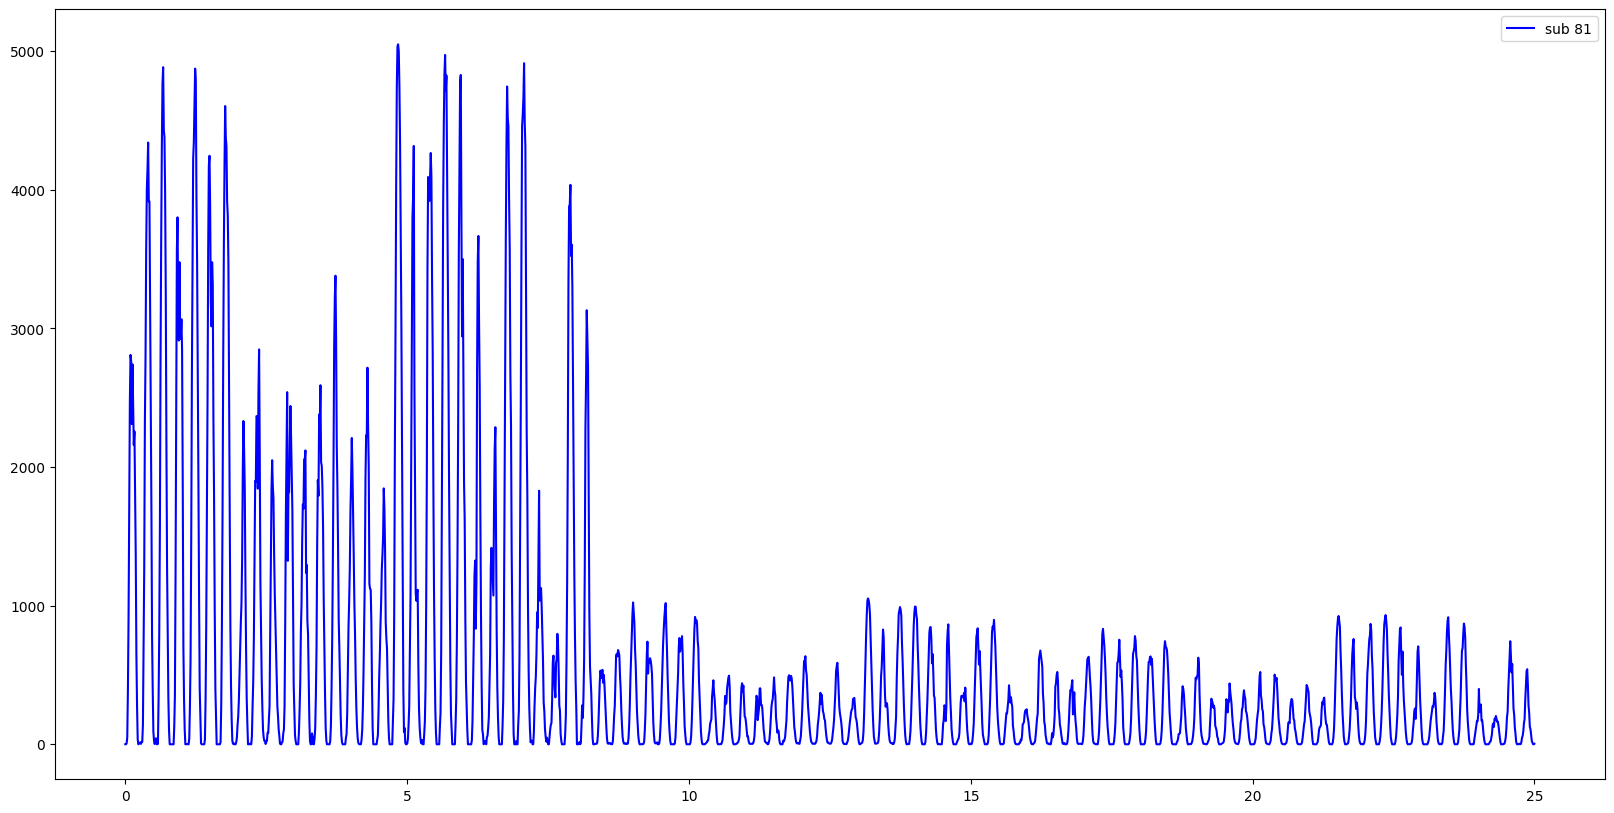

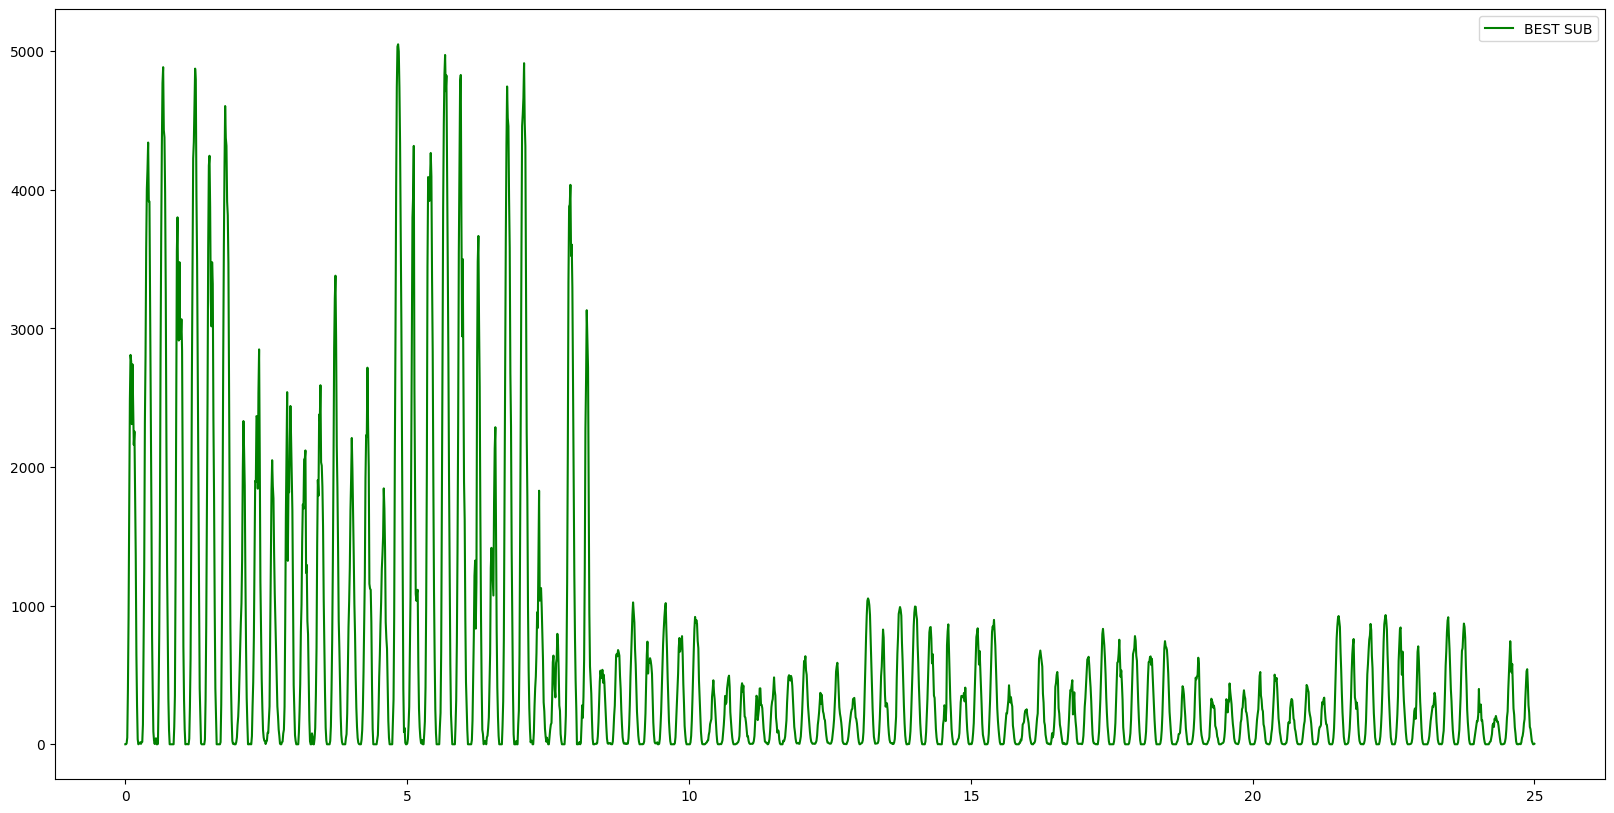

40.656517750470314
39.60431380880247
26.93752466606324
26.84170999887863
29.364976118915784
30.78217620063907
81.62795516861273
28.831478127324957


In [36]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_absolute_error
stack1_pred = pd.read_csv("stack_1.csv")
stack2_pred = pd.read_csv("stack_2.csv")
stack3_pred = pd.read_csv("stack_3.csv")
stack4_pred = pd.read_csv("stack_4.csv")
cat1_pred = pd.read_csv("catboost_1.csv")
gbr1_pred = pd.read_csv("gbr_1.csv")
ada1_pred = pd.read_csv("ada_1.csv")
lgbm1_pred = pd.read_csv("lgbm_1.csv")
best_pred = pd.read_csv("log_sub_4.csv")


diff = pd.DataFrame(stack2_pred) - pd.DataFrame(best_pred)

x = np.linspace(0, 25, 3*720)
y = [] 
  
with open('log_sub_4.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'b', label="sub 81") 
plt.legend()


y2 = []

with open('lgbm_1.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="BEST SUB") 
plt.legend() 
plt.show()


print(mean_absolute_error(best_pred, stack1_pred))
print(mean_absolute_error(best_pred, stack2_pred))
print(mean_absolute_error(best_pred, stack3_pred))
print(mean_absolute_error(best_pred, stack4_pred))
print(mean_absolute_error(best_pred, cat1_pred))
print(mean_absolute_error(best_pred, gbr1_pred))
print(mean_absolute_error(best_pred, ada1_pred))
print(mean_absolute_error(best_pred, lgbm1_pred))